In [1]:
!pip install -q -q -q geopandas
!pip install -q -q -q rasterio
!pip install -q -q -q py7zr

In [34]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio import features

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree
from sklearn.neighbors import RadiusNeighborsRegressor

Chargement des fonctions et des données

In [3]:
def rasterizeBlackWhite(sdf, size, points=True):
    """sdf : a geopandas DataFrame
       size : resolution
       points : if points is true return a pandas DataFrame, otherwise a numpy array"""
    bounds = sdf.total_bounds
    geometry = sdf.geometry
    xmin = np.floor(bounds[0] / size) * size
    ymin = np.floor(bounds[1] / size) * size
    xmax = np.ceil(bounds[2] / size) * size
    ymax = np.ceil(bounds[3] / size) * size
    geometry = geometry.translate(xoff=-xmin, yoff=-ymin, zoff=0.0)
    geometry = geometry.scale(xfact=1/size,yfact=1/size,origin=(0,0))
    width = int((xmax - xmin)/size)
    height = int((ymax - ymin)/size)
    raster = features.rasterize(geometry, (height,width),fill=0,all_touched=True)
    if points==True:
        y, x = np.where(raster) 
        return(pd.DataFrame({'x' : x * size + xmin , 'y' : y * size + ymin}))
    else:
        return(np.flip(raster.reshape(raster.shape[0], raster.shape[1]),0))

In [4]:
def neighbors_near_point(df, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    tree = KDTree(df[['x', 'y']]) 
    dist, ind = tree.query(df[['x', 'y']], np.max(list_of_radius))   
    for i, r in enumerate(list_of_radius):
        neighbors[:,i] =list(map(lambda x : np.sum(x <= r), dist)) 
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(pd.concat([df[['x', 'y']].reset_index(), result], axis=1))


def neighbors_near_point(df, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    tree = KDTree(df[['x', 'y']]) 
    for i, r in enumerate(list_of_radius):
        print(r)
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True) 
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(pd.concat([df[['x', 'y']].reset_index(), result], axis=1))


In [29]:
def Gwfa_en_un_point(df, x_centre, y_centre, list_of_radius):
    
    distance = (df.x - x_centre)** 2 + (df.y - y_centre)**2
    weight =  (1 - (distance / 16000**2))**2
    weight = weight / weight.sum()
    print(weight.sum())
    temp = df[[str(t) for t in list_of_radius]]
    temp = temp.mul(weight, axis=0)
    temp = pd.DataFrame({'radius': list_of_radius, 'sb': np.sum(temp,0)})
    return(temp)

### Calcul bocage

In [6]:
list_of_radius = np.array([25,50,100,200,400,800,1600])

In [7]:
bocage = gpd.read_file('building_bocage.gpkg')
r_bocage = rasterizeBlackWhite(bocage, 4)

In [8]:
neigh_bocage = neighbors_near_point(r_bocage, list_of_radius)

25
50
100
200
400
800
1600


In [30]:
sb_bocage = Gwfa_en_un_point(neigh_bocage,387380,6893920, list_of_radius)

1.0


In [31]:
sb_bocage

,radius,sb
25,25,42.086167
50,50,106.975866
100,100,263.030533
200,200,650.141158
400,400,1734.477364
800,800,4954.924984
1600,1600,14497.676566


In [32]:
lsb_bocage = np.log(sb_bocage)
d = np.polyfit(lsb_bocage['radius'],lsb_bocage['sb'],1)
f = np.poly1d(d)
lsb_bocage['line'] = f(lsb_bocage['radius'])
d

array([ 1.39546394, -0.82073591])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


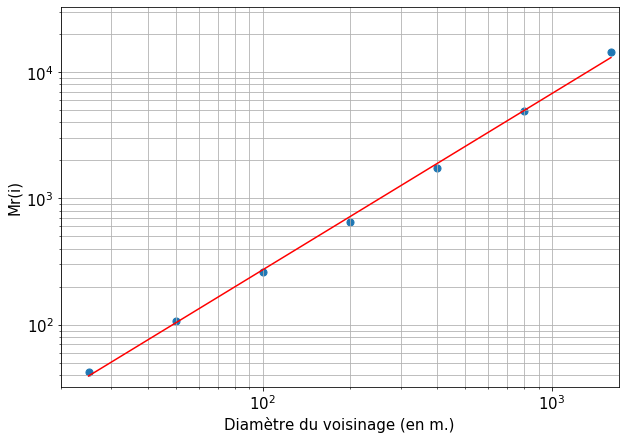

In [50]:
sb_bocage['exp_line'] = np.exp(lsb_bocage['line'])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
ax = sb_bocage.plot.scatter('radius','sb', loglog=True, figsize=(10,7),s=50)
ax.set_xlim((20, 1700))
ax.set_ylim((sb_bocage.sb.min()-10, sb_openfield.sb.max()+10000))
sb_bocage.plot.line('radius', 'exp_line',color='Red',ax=ax, legend=False)
plt.grid(which='both')
ax.set_xlabel('Diamètre du voisinage (en m.)')
ax.set_ylabel('Mr(i)')
plt.savefig("GWFA_D2_bocage.svg")

### Calcul openfield

In [40]:
openfield = gpd.read_file('building_openfield.gpkg')
r_openfield = rasterizeBlackWhite(openfield, 4)

In [41]:
neigh_openfield = neighbors_near_point(r_openfield, list_of_radius)

25
50
100
200
400
800
1600


In [42]:
sb_openfield = Gwfa_en_un_point(neigh_openfield,786645,6879505, list_of_radius)

1.0000000000000004


In [43]:
lsb_openfield = np.log(sb_openfield)
d = np.polyfit(lsb_openfield['radius'],lsb_openfield['sb'],1)
f = np.poly1d(d)
lsb_openfield['line'] = f(lsb_openfield['radius'])
d

array([ 1.45275527, -0.38418562])

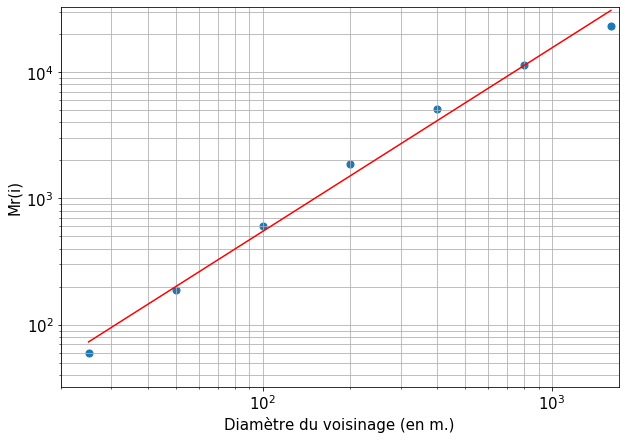

In [51]:
sb_openfield['exp_line'] = np.exp(lsb_openfield['line'])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
ax = sb_openfield.plot.scatter('radius','sb', loglog=True, figsize=(10,7),s=50)
ax.set_xlim((20, 1700))
ax.set_ylim((sb_bocage.sb.min()-10, sb_openfield.sb.max()+10000))
sb_openfield.plot.line('radius', 'exp_line',color='Red',ax=ax, legend=False)
plt.grid(which='both')
ax.set_xlabel('Diamètre du voisinage (en m.)')
ax.set_ylabel('Mr(i)')
plt.savefig("GWFA_D2_openfield.svg")

### Rasterization des fonds à 4 m

In [5]:
r_openfield = rasterizeBlackWhite(openfield, 4)

NameError: name 'openfield' is not defined

### Calcul des voisinages

In [ ]:
neigh_openfield = neighbors_near_point(r_openfield, np.array([25,50,100,200,400,800,1600])) 

### Calcul de la GWFA en un point

In [ ]:
def Gwfa_en_un_point(df, x_centre, y_centre, q):
    distance = (df.x - x_centre)** 2 + (df.y - y_centre)**2
    weight = (1 - (distance / 16000**2))**2
    


In [8]:
df = r_openfield.copy()
list_of_radius = np.array([25,50,100,200,400,800,1600])

In [9]:
neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)

In [10]:
tree = KDTree(df[['x', 'y']]) 

In [12]:
dist, ind = tree.query(df[['x', 'y']], np.max(list_of_radius))   

In [17]:
for i, r in enumerate(list_of_radius):
    neighbors[:,i] =list(map(lambda x : np.sum( x <= r), dist)) 